<a href="https://colab.research.google.com/github/PatrykCiwinski/RNN_eur_pln/blob/main/RNN_eur_pln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##DATA SHOWING EURO-PLN EXCHANGE RATE

In [2]:
df = pd.read_csv('/content/eurpln_d.csv',parse_dates=True,index_col='Data')

In [3]:
df.drop(df[['Otwarcie','Najwyzszy','Najnizszy']],axis=1,inplace=True)

In [4]:
df.columns=['EX']

<Axes: xlabel='Data'>

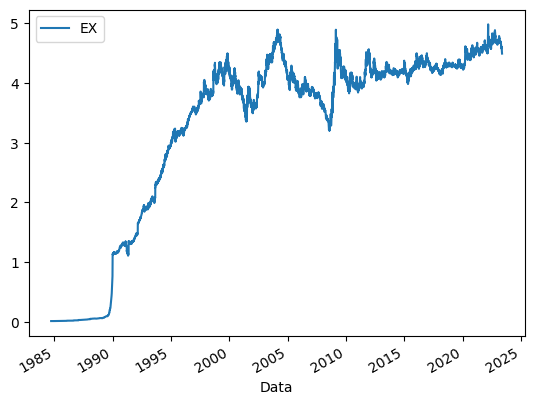

In [5]:
df.plot()

##Performing train/test split

In [6]:
len(df)

8634

In [7]:
split_point = len(df) - 600

In [8]:
split_point

8034

In [9]:
train = df[:split_point]

In [10]:
test =df[split_point:]

In [11]:
len(test)

600

#Scaling the data

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(train)

MinMaxScaler()

In [15]:
scaled_train = scaler.transform(train)

In [16]:
scaled_test = scaler.transform(test)

##Creating generators

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [33]:
length=6

In [51]:
generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=8)

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [53]:
n_features = 1


#Model

In [54]:
model =Sequential()

model.add(layers.LSTM(100, activation='relu',input_shape=(length, n_features)))
model.add(layers.Dense(100))

model.compile(optimizer='adam',loss='mse')

In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
Total params: 50,900
Trainable params: 50,900
Non-trainable params: 0
_________________________________________________________________


In [114]:
validation_generator=TimeseriesGenerator(scaled_test,scaled_test,length=5,batch_size=8) ##length is length-1 to prevent from error

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
es = EarlyStopping(monitor='val_loss',patience=2)

In [62]:
model.fit(generator,validation_data=validation_generator,epochs=20,
          callbacks=[es])

Epoch 1/20
1004/1004 [==============================] - 18s 16ms/step - loss: 0.0148 - val_loss: 0.0877
Epoch 2/20
1004/1004 [==============================] - 16s 15ms/step - loss: 1.9646e-04 - val_loss: 0.0904
Epoch 3/20
1004/1004 [==============================] - 15s 15ms/step - loss: 2.2209e-04 - val_loss: 0.0728
Epoch 4/20
1004/1004 [==============================] - 16s 16ms/step - loss: 2.1192e-04 - val_loss: 0.0699
Epoch 5/20
1004/1004 [==============================] - 16s 15ms/step - loss: 1.9481e-04 - val_loss: 0.0532
Epoch 6/20
1004/1004 [==============================] - 15s 15ms/step - loss: 2.0916e-04 - val_loss: 0.0498
Epoch 7/20
1004/1004 [==============================] - 15s 15ms/step - loss: 1.6418e-04 - val_loss: 0.0478
Epoch 8/20
1004/1004 [==============================] - 15s 15ms/step - loss: 1.9587e-04 - val_loss: 0.0390
Epoch 9/20
1004/1004 [==============================] - 15s 15ms/step - loss: 1.5996e-04 - val_loss: 0.0364
Epoch 10/20
1004/1004 [=========

In [63]:
losses=pd.DataFrame(model.history.history)


<Axes: >

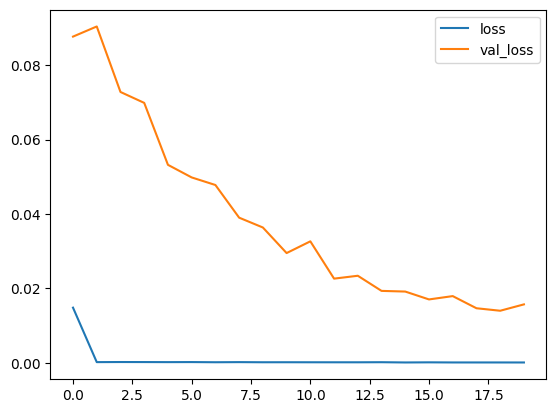

In [64]:
losses.plot()

##Performing the full data forecasting

In [81]:
full_scaler = MinMaxScaler()
data_scaled = full_scaler.fit_transform(df)

In [82]:
length = 10
full_generator = TimeseriesGenerator(data_scaled, data_scaled,length=length, batch_size=1)

In [83]:
model_full = Sequential()
model_full.add(layers.LSTM(100, activation='relu', input_shape=(length, n_features)))
model_full.add(layers.Dense(1))
model_full.compile(optimizer='adam', loss='mse')


# fit model
model_full.fit(full_generator,epochs=5)

Epoch 1/5
8624/8624 [==============================] - 192s 22ms/step - loss: 6.9623e-04
Epoch 2/5
8624/8624 [==============================] - 187s 22ms/step - loss: 1.1567e-04
Epoch 3/5
8624/8624 [==============================] - 187s 22ms/step - loss: 7.7595e-05
Epoch 4/5
8624/8624 [==============================] - 192s 22ms/step - loss: 5.6882e-05
Epoch 5/5
8624/8624 [==============================] - 188s 22ms/step - loss: 5.0070e-05


In [107]:
forecast = []

periods = 1400

first_eval_batch = data_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model_full.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 20ms/step


In [108]:
forecast = scaler.inverse_transform(forecast)

In [109]:
df

,EX
Data,
1984-09-24,0.00920
1984-10-01,0.00940
1984-10-08,0.00920
1984-10-15,0.00920
1984-10-22,0.00900
...,...
2023-05-10,4.52049
2023-05-11,4.53898
2023-05-12,4.51898


#Forecast index starts where the original df index ends

In [115]:
forecast_index = pd.date_range(start='2023-05-17',periods=periods) ##periods to forecast are 1400 days

In [111]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [112]:
forecast_df

,Forecast
2023-05-17,4.426439
2023-05-18,4.441886
2023-05-19,4.456160
2023-05-20,4.468896
2023-05-21,4.480171
...,...
2027-03-12,5.142322
2027-03-13,5.142322
2027-03-14,5.142322
2027-03-15,5.142322


##Displaying the plot of forecasted exchange rate

(11103.0, 20964.0)

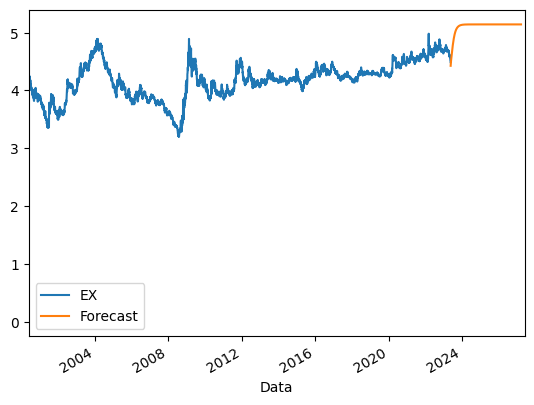

In [113]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2000-05-26','2027-05-26')